# Bayesian Decision Analysis with PyMC

This notebook is based on the first notebook of the [Bayesian Modeling Workshop](https://github.com/pymc-labs/pymc-workshop/) offered by PyMC Labs.

[Open this notebook (no solutions) in Colab](https://colab.research.google.com/github/AllenDowney/BDAwithPyMC/blob/main/notebooks/01_beta_binomial.ipynb)

[Open this notebook (with solutions) in Colab](https://colab.research.google.com/github/AllenDowney/BDAwithPyMC/blob/main/solutions/01_beta_binomial.ipynb)

In [1]:
# Install preliz if needed
try:
    import preliz as pz
except ImportError:
    %pip install preliz

In [2]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import preliz as pz

In [3]:
# Make the figures a little smaller so we fit more on the screen
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = (6.4, 3.2)

In [4]:
# Change the way NumPy 2.0 displays floats
np.set_printoptions(legacy="1.25")

## Part 1: The Beta-Binomial Model

In digital marketing, A/B testing is used to evaluate the effect of different versions of an ad, web page, etc. 
More generally, it has the same structure as tests of medical treatments, public policy interventions, product design, and more.

As an example, suppose we test an email campaign that includes a promotional offer.
We send version A to 100 people, and 8 of them accept the offer.
So the observed conversion rate in this sample is 8%.

Here's a dictionary that represents the results.

In [5]:
A = dict(n=100, k=8)

Some questions we'd like to answer:

* What is the probability someone responds to this email?
* How confident are we about that estimate?
* If we send the same email to 100 people, how many will respond?

And if we have more than one version of the email, we want to compare them.

To answer these questions, we'll use the beta-binomial model:

* A beta distribution to represent what we believe about the conversion rate.
* A binomial to represent the distribution of outcomes (number of responses).

## The beta distribution

The first step is to define a prior distribution that represents what we believe about conversion rates of ads like this one, in general, before we consider the data.

We'll use a beta distribution because it's defined from 0 to 1, which is the right domain for a probability, and it has parameters we can choose to specify the location and width of the prior.

Here's the beta distribution we'll use for this example.

In [6]:
from preliz import Beta

dist = Beta(2, 5)
dist.mean(), dist.std()

(0.2857142857142857, 0.15971914124998499)

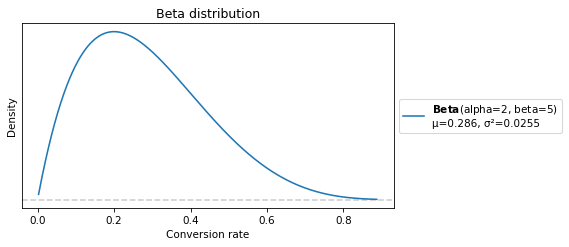

In [7]:
dist.plot_pdf(moments="mv")
plt.xlabel("Conversion rate")
plt.ylabel("Density")
plt.title("Beta distribution");

With these parameters, the mean is about `0.28`, which means we think a typical response rate is about 28%.
But the width of the distribution indicates that we are very unsure about that.

## The binomial distribution

Now let's pick an arbitrary single value from the prior, `0.2`, and suppose we send 50 emails with that response rate.
The binomial distribution shows how many responses we should expect.

In [8]:
from preliz import Binomial

dist = Binomial(50, 0.2)
dist.mean()

10.0

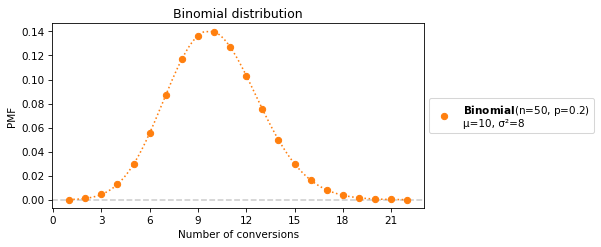

In [9]:
dist.plot_pdf(moments="mv", color="C1")
plt.xlabel("Number of conversions")
plt.ylabel("PMF")
plt.title("Binomial distribution");

The mean is 10, but values as low as 2 and as high as 20 have non-negligible probability.

In general we don't know the response rate -- we have to estimate it from data.

## The Bayesian Update

The fundamental idea in Bayesian statistics is that we can use data to update our beliefs.

* We start with a **prior distribution** that represents what we believe before we see the data,

* We compute a **posterior distribution** that represents what we believe after we see the data.

There are several ways to do this computation:

* Mathematically, or

* Computationally, using a grid approximation, variational inference, or MCMC.

MCMC is [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling, which takes a prior distribution and data, and generates a random sample from an approximate posterior distribution.

PyMC provides several MCMC algorithms along with distributions we can use to assemble a model of the data-generating process.

In this example, we model the data-generating process as:

* Choose a conversion rate from the prior, which is a beta distribution

* Choose a number of conversions from the likelihood, which is a binomial distribution

Exercise: Fill in this model with a beta prior and binomial likelihood.

In [10]:
# Fill this in

with pm.Model() as model:
    # Prior
    conversion_rate = 0
    
    # Likelihood
    pm.Binomial("obs", p=0, n=0, observed=0)

In [11]:
# Solution

with pm.Model() as model:
    # Prior
    conversion_rate = pm.Beta("conversion_rate", 2, 5)

    # Likelihood
    pm.Binomial("obs", p=conversion_rate, n=A["n"], observed=A["k"])

Here's a graphical representation of the model.

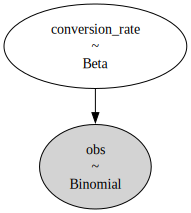

In [12]:
pm.model_to_graphviz(model)

First, let's draw a sample from the prior distribution.

In [13]:
with model:
    prior_idata1 = pm.sample_prior_predictive()

Sampling: [conversion_rate, obs]


Here's what it looks like.

In [14]:
def plot_prior(idata, **options):
    return az.plot_posterior(idata, group="prior", hdi_prob="hide", **options)

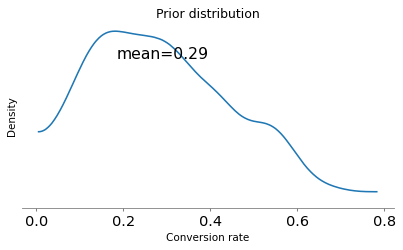

In [15]:
plot_prior(prior_idata1)
plt.xlabel("Conversion rate")
plt.ylabel("Density")
plt.title("Prior distribution");

The result looks like the PDF of the beta distribution we computed.

Now let's sample from the posterior.

In [16]:
with model:
    idata1 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Here's what the posterior distribution looks like.

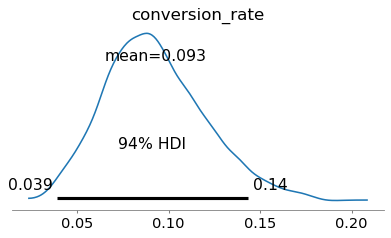

In [17]:
az.plot_posterior(idata1);

The posterior distribution represents what we believe **after seeing the data**.
It's centered near the observed conversion rate, 8%.

The 94% HDI extends from 4.5% to 14%.
Which means there is a 94% chance that the true conversion rate falls in this range, subject to the assumptions of the model (for example that rate does not change over time).

To compare the prior and posterior distributions, we'll combine `idata1` and `prior_idata1`.

In [18]:
with model:
    idata1.extend(prior_idata1)

And then we can use `plot_dist_comparison`.

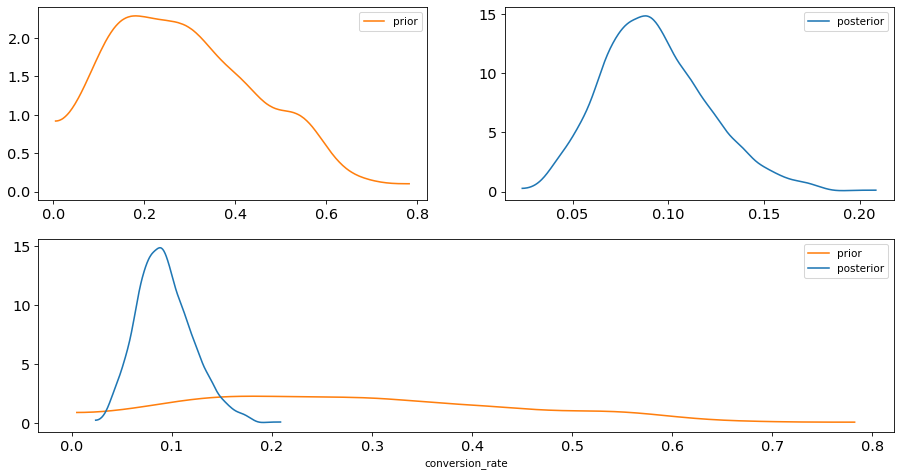

In [19]:
az.plot_dist_comparison(idata1);

In summary:

* The prior distribution represents what we believe about the conversion rate before seeing the data.

* The posterior distribution represents what we believe about the conversion rate after seeing the data.

As we get more data, the posterior distribution gets narrower.

### What About That Prior?

The previous example uses a **weakly informative prior** -- based on what we know about email campaigns, we think the response rate could fall anywhere in a wide range.

Weakly informative priors "let the data speak for itself".

But when you have only a small dataset, the prior makes a big difference, so you should use as much information as you have.

Here's a problem that illustrates the point, from Chapter 4 of [Think Bayes](https://allendowney.github.io/ThinkBayes2/chap04.html#exercises).

> In Major League Baseball, most players have a batting average between .170 and .310, which means that their probability of getting a hit is between 0.17 and 0.31.
>
> Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

Here's a model that estimates a proportion after observing `k=3` successes out of `n=3` attempts.
It uses a weakly informative prior (the same one we used for the email campaign).

In [20]:
with pm.Model() as model_rookie:
    batting_average = pm.Beta("p", 2, 5)  
    pm.Binomial("obs", p=batting_average, n=3, observed=3)
    
    prior_idata2 = pm.sample_prior_predictive()
    idata2 = pm.sample()

Sampling: [obs, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's what that prior looks like.

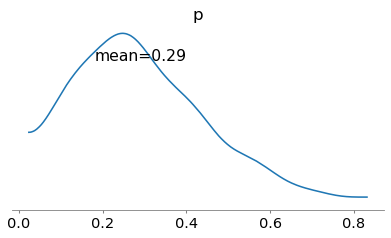

In [21]:
plot_prior(prior_idata2);

Here's the posterior.

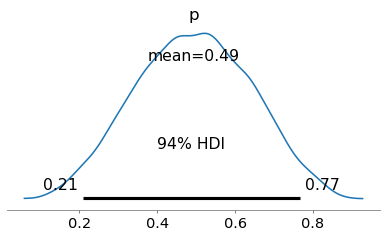

In [22]:
az.plot_posterior(idata2);

In this case, "letting the data speak for itself" yields an unrealistic result.

We have a lot of information about batting averages in the major leagues, which we can use to choose a more reasonable prior.

We can specify the prior in terms of mean and dispersion, and convert to the parameters of the beta distribution.

In [23]:
def compute_params(mean, std):
    alpha = mean * ((mean * (1 - mean)) / std**2 - 1)
    beta = (1 - mean) * ((mean * (1 - mean)) / std**2 - 1)
    return alpha, beta

In [24]:
alpha, beta = compute_params(mean=0.240, std=0.070)
alpha, beta

(8.693877551020407, 27.53061224489796)

Exercise: Go back and modify the prior of `model_rookie`.
Compute and plot the posterior, and see what effect the new prior has on the results.
Given what we know about the context, do the results seem more reasonable?

This example demonstrates the Bayesian version of [shrinkage](https://en.wikipedia.org/wiki/Shrinkage_(statistics)), so called because an estimate based on small data "shrinks" toward the prior mean.

## Part 2: Bayesian Bandits

Let's get back to the first example, estimating the conversion rate of an email campaign.

For purposes of simulation, let's assume that the actual long run conversion rate for version A is 10%.
We'll use a dictionary to keep track of this probability, `p`, the number of times we have tested this version, `n`, and the number of successful conversions, `k`.

In [25]:
A = dict(p=0.1, n=0, k=0)

When we run a campaign, we'll update this dictionary with the number of people we contact and the number of conversions, drawn from a binomial distribution with parameters `n` and `p`.

This function uses a PyMC distribution as a random number generator.
This usage is not common, but it can be useful with distributions that have different parameters in different libraries. 
If you use PyMC for everything, compatibility is ensured.

In [26]:
def run_campaign(d, n=100):
    # Draw the number of successes for this campaign
    dist = pm.Binomial.dist(n=n, p=d["p"])
    k = pm.draw(dist)
    
    # Update totals
    d["n"] += n
    d["k"] += k

As an example, suppose we send version A to 100 people.

In [27]:
run_campaign(A, 100)
A

{'p': 0.1, 'n': 100, 'k': 8}

We can use this model to estimate the conversion rate.

In [28]:
with pm.Model() as model_A:
    conversion_rate = pm.Beta("conversion_rate", 2, 5)
    pm.Binomial("obs", p=conversion_rate, n=A["n"], observed=A["k"])
    
    idata3 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's the posterior distribution.

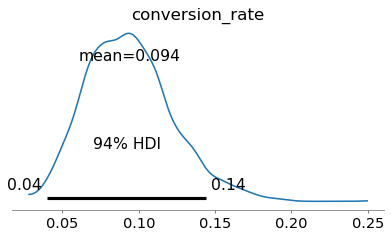

In [29]:
az.plot_posterior(idata3);

Now suppose we introduce a new promotion that we think is more enticing, and for the sake of the example, we'll assume it is in fact more effective, so `p=0.15`.

In [30]:
B = dict(p=0.15, n=0, k=0)

But we don't know yet that B is more effective, so we'll do an uneven A/B test where we send the new email to 20 people in the next batch of 100.

In [31]:
run_campaign(A, 80)
A

{'p': 0.1, 'n': 180, 'k': 12}

In [32]:
run_campaign(B, 20)
B

{'p': 0.15, 'n': 20, 'k': 3}

Now let's update our beliefs.

### Loop Back to Here

Here's the previous model extended to estimate conversion rates for A and B.

In [33]:
with pm.Model() as model_AB:
    
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", 2, 5)
    conversion_rate_B = pm.Beta("conversion_rate_B", 2, 5)
    
    # Likelihoods for observed data
    pm.Binomial("obs_A", p=conversion_rate_A, n=A["n"], observed=A["k"])
    pm.Binomial("obs_B", p=conversion_rate_B, n=B["n"], observed=B["k"])

    idata4 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Here are the posterior distributions.

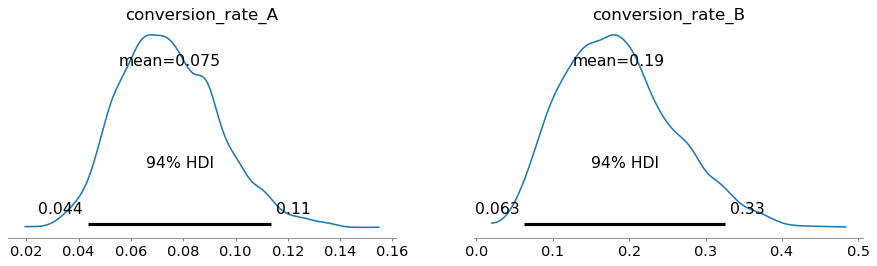

In [34]:
az.plot_posterior(idata4);

Here's how we can plot them on the same axes.

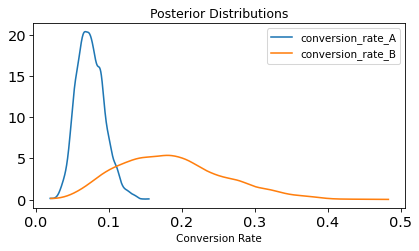

In [35]:
posterior = az.extract(idata4)
samples_A = posterior["conversion_rate_A"].values
samples_B = posterior["conversion_rate_B"].values

az.plot_kde(samples_A, label="conversion_rate_A")
az.plot_kde(samples_B, label="conversion_rate_B", plot_kwargs={"color": "C1"})

plt.xlabel("Conversion Rate")
plt.title("Posterior Distributions")
plt.legend();

Based on these results, it looks like B is better, but the distributions overlap, so we might be tempted to run a hypothesis test.

But rather than merely distinguishing between "yes, there's a difference" or "no, there isn't", it is more useful to compute the **distribution** of possible differences. We want to know **how different** the conversion rates are, not just whether they are different.

In [36]:
diff = samples_B - samples_A

Here's what it looks like.

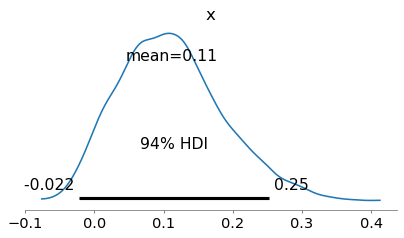

In [37]:
az.plot_posterior(diff, var_names=["x"]);

On average, we think B is better (positive difference), but it's still possible that A is better (negative difference).

Here are the probabilities of superiority for A and B.

In [38]:
p_superior_A = (samples_A > samples_B).mean()
p_superior_B = (samples_B > samples_A).mean()

p_superior_A, p_superior_B

(0.054, 0.946)

At any point in time, these posterior distributions represent what we *believe* about A and B, but **how do we put those beliefs into action?**

### Thompson Sampling

One option is [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling), where we use A and B in proportion to their probability of superiority.
As long as we are unsure, we use them both about equally.
As we get confident that one is better, we use it more often.

For the next 100 emails, we'll use the probability of superiority to choose the proportions.

In [39]:
n = 100
n_A = (n * p_superior_A).round().astype(int)
n_B = n - n_A

n_A, n_B

(5, 95)

And we'll simulate the campaign.

In [40]:
run_campaign(A, n_A)
A

{'p': 0.1, 'n': 185, 'k': 13}

In [41]:
run_campaign(B, n_B)
B

{'p': 0.15, 'n': 115, 'k': 20}

Now go back and run the model again.
If you loop around a few times, you should see:

* The estimated conversion rates for A and B converge to their true values.

* The probability of superiority of B converges to 1.

* We gradually use A less and B more.

This strategy, also known as the [Bayesian bandit strategy](https://en.wikipedia.org/wiki/Multi-armed_bandit), is optimal in the sense that it maximizes expected utility given current beliefs.

## Part 3: Hierarchical Models

Our next step is to make a hierarchical version of the model, where the parameters of the prior distribution are drawn from yet another distribution.

To represent the distributions of these parameters, we'll use a gamma distribution.
It's a continuous distribution, defined for non-negative numbers, so it is often used to represent a distribution of possible rates, like events per unit of time.

There are different ways to parameterize the gamma distribution -- we'll use the shape-rate form, with parameters called `alpha` and `beta`.
(Sorry about all the Greek letters!)

In [42]:
alpha = 16
beta = 8

We'll use PreliZ again to represent this distribution.

In [43]:
from preliz import Gamma

dist = Gamma(alpha, beta)
dist.mean(), dist.std()

(2.0, 0.5)

Here's what it looks like.

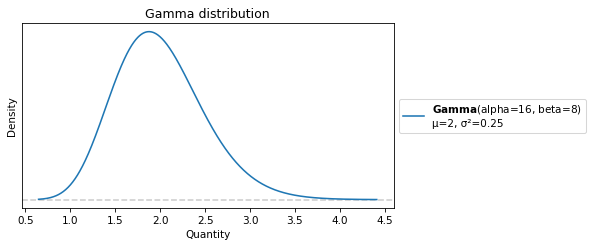

In [44]:
dist.plot_pdf(moments="mv")
plt.xlabel("Quantity")
plt.ylabel("Density")
plt.title("Gamma distribution");

Now we're ready to build a hierarchical model.

### Bandits Revisited

Continuing the A/B testing example, suppose we have an old email we have sent 200 times, and we get 20 conversions.

In [45]:
A = dict(p=0.1, n=200, k=20)
A

{'p': 0.1, 'n': 200, 'k': 20}

In [46]:
obs_proportion_A = A["k"] / A["n"]
obs_proportion_A

0.1

And a new version we have sent only 10 times, with two conversions.

In [47]:
D = dict(p=0.2, n=10, k=2)
D

{'p': 0.2, 'n': 10, 'k': 2}

In [48]:
obs_proportion_D = D["k"] / D["n"]
obs_proportion_D

0.2

Here's the model that estimates conversion rates for A and D.

In [49]:
with pm.Model() as model_AD:
    # Priors for conversion rates of A and D
    conversion_rate_A = pm.Beta("conversion_rate_A", 2, 5)
    conversion_rate_D = pm.Beta("conversion_rate_D", 2, 5)
    
    # Likelihoods for observed data
    pm.Binomial("obs_A", p=conversion_rate_A, n=A["n"], observed=A["k"])
    pm.Binomial("obs_D", p=conversion_rate_D, n=D["n"], observed=D["k"])
    
    idata5 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Here are the posterior distributions, showing the observed proportions as reference values.

In [50]:
parameters = ["conversion_rate_A", "conversion_rate_D"]
obs_proportions = [obs_proportion_A, obs_proportion_D]

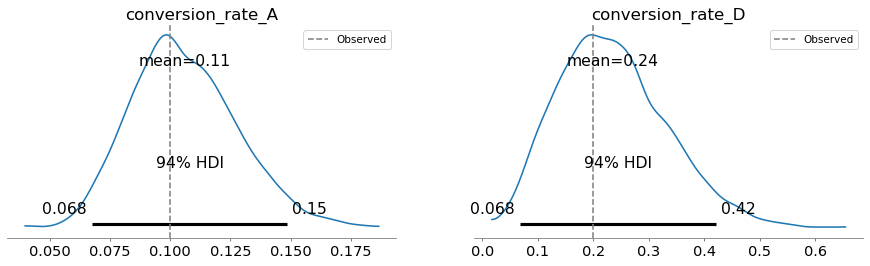

In [51]:
axes = az.plot_posterior(idata5, var_names=parameters)

for ax, x in zip(axes, obs_proportions):
    ax.axvline(x=x, color="gray", linestyle="--", label="Observed")
    ax.legend()

In this model, the conversion rates are independent -- the data from A doesn't affect the posterior distribution for D, and vice versa.

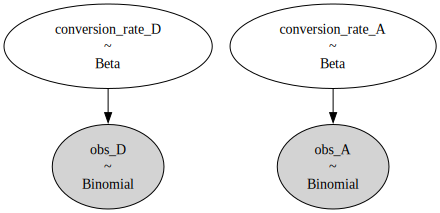

In [52]:
pm.model_to_graphviz(model_AD)

And that means we are leaving information on the table: assuming A and D are similar, what we learn about A gives us information about the effectiveness of campaigns like this in general, which influences what we should believe about D.

We can take advantage of this additional information by making the model hierarchical.

In [53]:
# Modify this

with pm.Model() as model_hierarchical:
    # Priors for conversion rates of A and D
    conversion_rate_A = pm.Beta("conversion_rate_A", 2, 5)
    conversion_rate_D = pm.Beta("conversion_rate_D", 2, 5)
    
    # Likelihoods for observed data
    pm.Binomial("obs_A", p=conversion_rate_A, n=A["n"], observed=A["k"])
    pm.Binomial("obs_D", p=conversion_rate_D, n=D["n"], observed=D["k"])

In [54]:
# Solution

with pm.Model() as model_hierarchical:
    # Hyperpriors for the Beta distributions of A and D
    alpha = pm.Gamma("alpha", 16, 8)  # Hyperprior for the shape parameter
    beta = pm.Gamma("beta", 40, 8)    # Hyperprior for the scale parameter
    
    # Priors for conversion rates of A and D, sharing hyperparameters
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha, beta)
    conversion_rate_D = pm.Beta("conversion_rate_D", alpha, beta)

    # come back and add this later
    conversion_rate_new = pm.Beta("conversion_rate_new", alpha, beta)
    
    # Likelihoods for observed data
    pm.Binomial("obs_A", p=conversion_rate_A, n=A["n"], observed=A["k"])
    pm.Binomial("obs_D", p=conversion_rate_D, n=D["n"], observed=D["k"])

The graphical representation of the model shows how the campaigns interact with each other through the hyperparameters. 

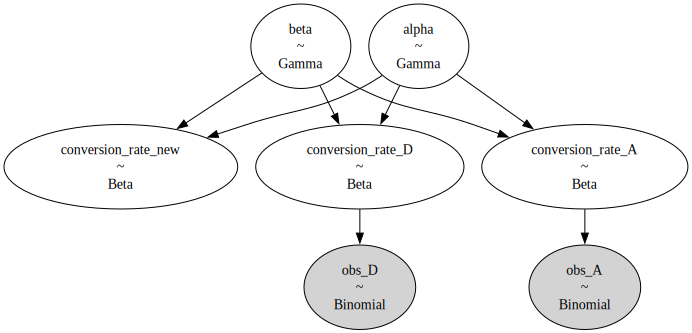

In [55]:
pm.model_to_graphviz(model_hierarchical)

Let's sample the priors.

In [56]:
with model_hierarchical:
    prior_idata6 = pm.sample_prior_predictive()

Sampling: [alpha, beta, conversion_rate_A, conversion_rate_D, conversion_rate_new, obs_A, obs_D]


Here's what the hyperpriors look like.

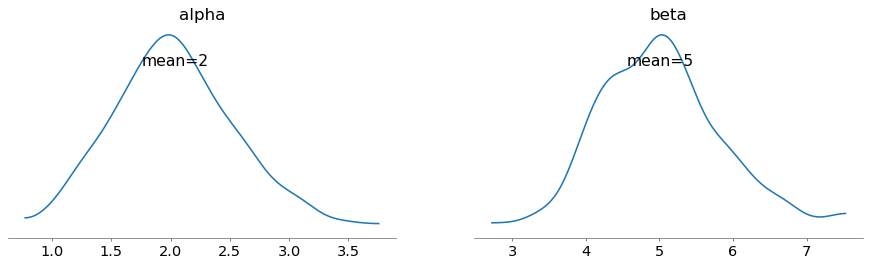

In [57]:
hyperparameters = ["alpha", "beta"]
plot_prior(prior_idata6, var_names=hyperparameters);

The means are close to 2 and 5, which were the fixed parameters we used in the previous version.
So the priors for the conversion rates are similar to what we had before.

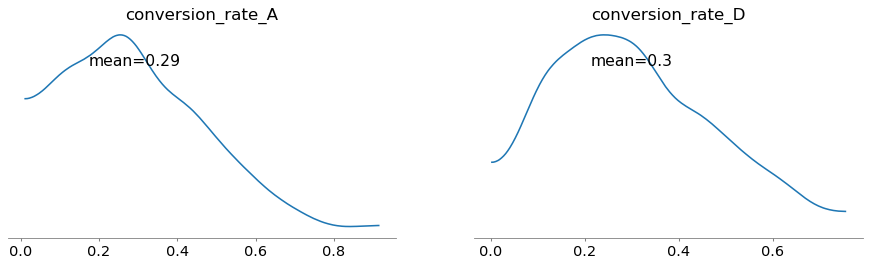

In [58]:
parameters = ['conversion_rate_A', 'conversion_rate_D']
plot_prior(prior_idata6, var_names=parameters);

Now when we sample, we simultaneously update beliefs about the conversion rates *and* the hyperparameters.

In [59]:
with model_hierarchical:
    idata6 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, conversion_rate_A, conversion_rate_D, conversion_rate_new]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Here are the posteriors for the hyperparameters.

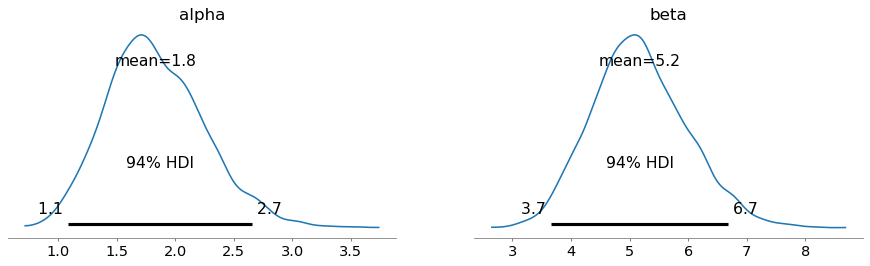

In [60]:
az.plot_posterior(idata6, var_names=hyperparameters);

Finally, here are the posteriors for the conversion rates, showing the observed proportions as reference values.

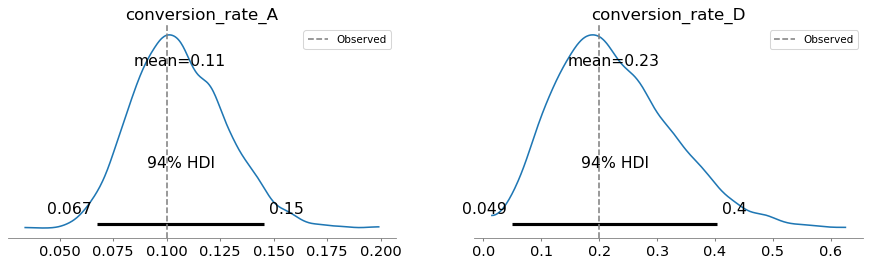

In [61]:
axes = az.plot_posterior(idata6, var_names=parameters)

for ax, x in zip(axes, obs_proportions):
    ax.axvline(x=x, color="gray", linestyle="--", label="Observed")
    ax.legend()

In this example, the effect of the hierarchical model is small -- the posterior means are about the same as the ones we got from the non-hierarchical model.
If we had more versions of the email, we would see more interaction.

But even in this case, the hierarchical model has a useful feature: the posterior distributions of `alpha` and `beta` represent what we learned about campaigns in general, based on the results from A and D.
Together they imply a posterior belief about the conversion rate of a new, untested version.

To generate samples for a new, untested version, we can add a new variable to the model

```
    conversion_rate_new = pm.Beta("conversion_rate_new", alpha, beta)
```

Because we have no observed data for this variable, its posterior distribution is based on the posterior distributions of the hyperparameters `alpha` and `beta`, which were updated based on the data from A and D.

Here's what it looks like.

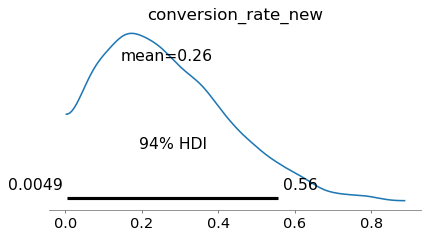

In [62]:
az.plot_posterior(idata6, var_names=["conversion_rate_new"]);

Because the response rates of A and D are below the prior mean, the posterior mean is lower than the prior mean (0.29).

### Posterior Predictive Distributions

So far we have run 

* `pm.sample_prior_predictive`, which samples from the prior distribution (and the prior predictive distribution, which we won't talk about today), and

* `pm.sample`, which samples from the posterior distribution.

Now we'll run `sample_posterior_predictive`, which samples from the **posterior predictive distribution**, which is the distribution of the data we expect if we run the same experiment again.

In [63]:
with model_hierarchical:
    posterior_pred = pm.sample_posterior_predictive(idata6)
    idata6.extend(posterior_pred)

Sampling: [obs_A, obs_D]


Output()

We'll use this function to plot it.

In [64]:
def plot_posterior_predictive(idata, **options):
    return az.plot_posterior(idata, group="posterior_predictive", **options);

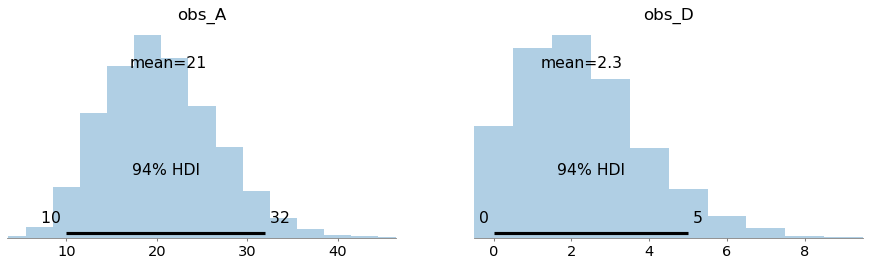

In [65]:
plot_posterior_predictive(idata6);

These distributions predict the number of conversions we expect if we run the same campaign again -- with the same values of `n` -- given our posterior beliefs about the conversion rates.

These distributions represent two sources of uncertainty:

* We don't know exactly what the conversion rates are, and

* Even if we did, we don't know how many conversions we would get.

The first is *epistemic*, because it relates to what we know.
The second is *aleatoric*, because it relates to randomness (literally "dice").

As we learn more, the first source of uncertainty gets smaller; the second does not.

## Hierarchical Baseball

In the previous example, with only two campaigns, the hierarchical model doesn't learn very much about campaigns in general, so it doesn't impose a lot of shrinkage.

Now let's look at an example with more data -- baseball!
Here's a dataset borrowed from Bill Engels's tutorial on Gaussian processes.

In [66]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/bwengals/pydata_global_2024_GPs/raw/main/data/batting_2023.csv")

The dataset includes every batter who had at least one "at bat" in Major League Baseball (MLB).

In [67]:
df = pd.read_csv("batting_2023.csv", encoding="unicode_escape")
df["Name"] = df["Name"].str.encode("latin-1").str.decode("utf-8")

Here are the batters with the lowest batting averages.

In [68]:
cols = ["Name", "Tm", "AB", "H", "BA"]
df.sort_values(by="BA")[cols].head(10)

,Name,Tm,AB,H,BA
388,Shelby Miller,Los Angeles,1,0,0.0
390,Calvin Mitchell,Pittsburgh,4,0,0.0
291,Connor Kaiser,Colorado,4,0,0.0
530,Braden Shewmake,Atlanta,4,0,0.0
328,Irving Lopez,St. Louis,11,0,0.0
517,Josh Sborz,Texas,1,0,0.0
626,Adam Wainwright,St. Louis,2,0,0.0
618,Meibrys Viloria,Cleveland,3,0,0.0
524,Chandler Seagle,San Diego,1,0,0.0
112,Diego Castillo,Arizona,1,0,0.0


And the highest.

In [69]:
df.sort_values(by="BA")[cols].tail(10)

,Name,Tm,AB,H,BA
629,Forrest Wall,Atlanta,13,6,0.462
452,Michael Pérez,New York,8,4,0.500
327,Alejo López,Cincinnati,2,1,0.500
125,Zack Collins,Cleveland,4,2,0.500
597,Cole Tucker,Colorado,8,4,0.500
142,Charlie Culberson,Atlanta,1,1,1.000
135,Kutter Crawford,Boston,0,0,NaN
307,Mark Kolozsvary,Baltimore,0,0,NaN
495,José Rodriguez,Chicago,0,0,NaN
543,Nick Solak,"Atlanta,Detroit",0,0,NaN


And here's the distribution.

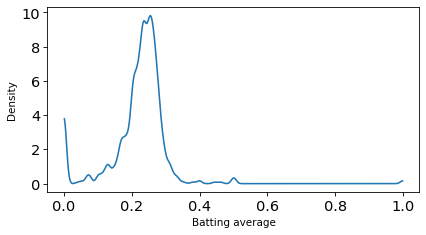

In [70]:
az.plot_dist(df["BA"], kind="kde")
plt.xlabel("Batting average")
plt.ylabel("Density");

What do you notice about the players with the lowest and highest batting averages?

Now let's make a hierarchical model to estimate batting averages for everyone in the league.

In [71]:
at_bats = df["AB"].values
hits = df["H"].values
n_players = len(df)
n_players

660

In [72]:
# Modify this

with pm.Model() as model_baseball:
    # Hyperpriors for the Beta distributions of A and D
    alpha = pm.Gamma("alpha", 16, 8)  # Hyperprior for the shape parameter
    beta = pm.Gamma("beta", 40, 8)    # Hyperprior for the scale parameter
    
    # Priors for conversion rates of A and D, sharing hyperparameters
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha, beta)
    conversion_rate_D = pm.Beta("conversion_rate_D", alpha, beta)
    
    # Likelihoods for observed data
    pm.Binomial("obs_A", p=conversion_rate_A, n=A["n"], observed=A["k"])
    pm.Binomial("obs_D", p=conversion_rate_D, n=D["n"], observed=D["k"])

In [73]:
# Solution

with pm.Model() as model_baseball:
    # Hyperpriors for the Beta distribution
    alpha = pm.Gamma("alpha", 16, 8)  # Hyperprior for the shape parameter
    beta = pm.Gamma("beta", 40, 8)    # Hyperprior for the scale parameter
    
    # Player-level batting averages sharing the same Beta prior
    player_ba = pm.Beta("player_ba", alpha=alpha, beta=beta, shape=n_players)
    player_new = pm.Beta("player_new", alpha, beta)
    
    # Likelihood for observed hits
    pm.Binomial("hits", p=player_ba, n=at_bats, observed=hits)

In [74]:
with model_baseball:
    idata7 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, player_ba, player_new]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


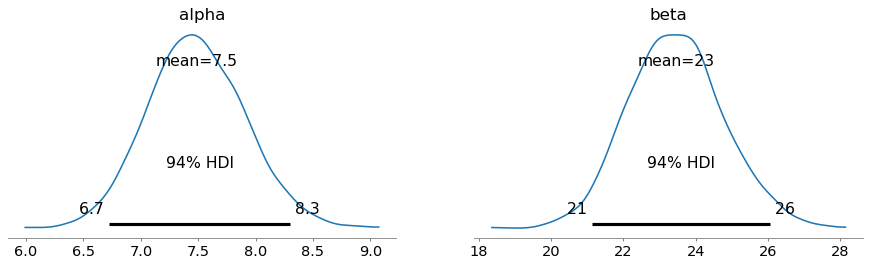

In [75]:
az.plot_posterior(idata7, var_names=hyperparameters);

The posterior distribution of the hyperparameters implies this posterior distribution for a new player.

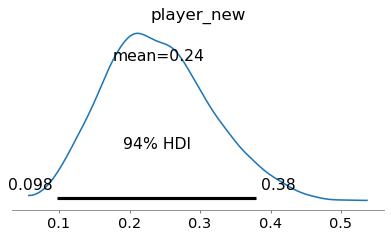

In [76]:
az.plot_posterior(idata7, var_names=["player_new"]);

Now let's see what the model inferred about the players.
We'll use this function to summarize the posterior for a given player.

In [77]:
def plot_posterior_player(df, idata, name):
    row = df.query('Name == @name')
    display(row[cols])

    # Get the index for the player you want
    idx = row.index[0]

    # Extract posterior samples for that specific player
    player_ba_samples = idata.posterior["player_ba"].sel(player_ba_dim_0=idx)

    # Plot
    az.plot_posterior(player_ba_samples)
    plt.axvline(x=row["BA"].values, color="gray", linestyle="--", label="Observed BA")
    plt.title(name)
    plt.legend()

,Name,Tm,AB,H,BA
595,Chadwick Tromp,Atlanta,16,2,0.125


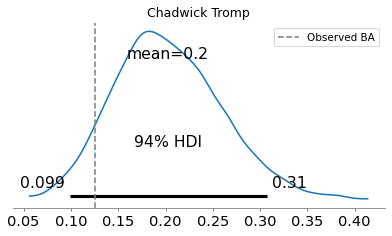

In [78]:
name = "Chadwick Tromp"
plot_posterior_player(df, idata7, name)

,Name,Tm,AB,H,BA
633,Jared Walsh,Los Angeles,104,13,0.125


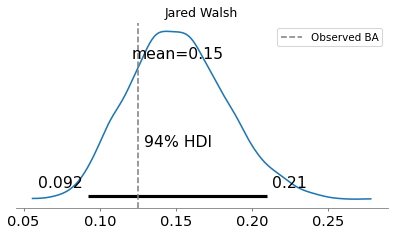

In [79]:
name = "Jared Walsh"
plot_posterior_player(df, idata7, name)

,Name,Tm,AB,H,BA
629,Forrest Wall,Atlanta,13,6,0.462


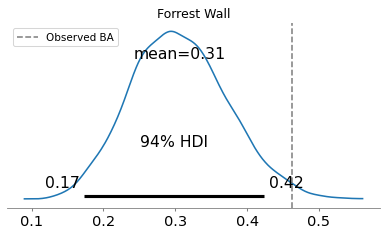

In [80]:
name = "Forrest Wall"
plot_posterior_player(df, idata7, name)

,Name,Tm,AB,H,BA
135,Kutter Crawford,Boston,0,0,NaN


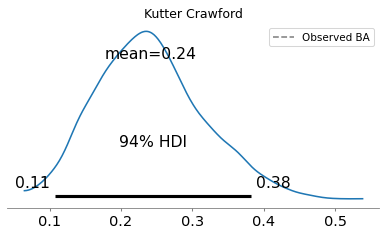

In [81]:
name = "Kutter Crawford"
plot_posterior_player(df, idata7, name)

Baseball mystery: how do you score a run without a plate appearance?

In [82]:
row = df.query("Name == 'Kutter Crawford'")
row.iloc[0]

Unnamed: 0                141
Name          Kutter Crawford
Age                        27
#days                     592
Lev                    Maj-AL
Tm                     Boston
G                           1
PA                          0
AB                          0
R                           1
H                           0
2B                          0
3B                          0
HR                          0
RBI                         0
BB                          0
IBB                         0
SO                          0
HBP                         0
SH                          0
SF                          0
GDP                         0
SB                          0
CS                          0
BA                        NaN
OBP                       NaN
SLG                       NaN
OPS                       NaN
mlbID                  676710
Name: 135, dtype: object

[Answer](https://www.boston.com/sports/boston-red-sox/2023/04/19/kutter-crawford-used-as-a-runner)